<h1><center>Evaluation apprentissage par renforcement</center></h1>
<h3><center>Groupe : Aymen BOUHOU - Mohammed Zineddine BOUCHERIR - El Mehdi BECHNIKHA<h3><center>

### Importation des bibliotheques

In [1]:
import base
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import warnings
warnings.filterwarnings("ignore")

### Execice 1 - Prédiction 

##### Question 1

Implémentation de l'algorithme de prédiction Monte-Carlo (MC)

In [2]:
def MC(pi,env, nb_episode=100, gamma=0.5, na=4):

    nbr_state = env.get_nb_states()
    S = np.zeros(nbr_state)
    V = np.zeros(nbr_state)
    n = np.zeros(nbr_state)

    for i in range(nb_episode):
        final = False
        s = env.reset()
        episode = []
    
        while not final:
            a = np.random.choice(na, p=pi[s])
            ns, r, final, _ = env.step(a)
            episode.append([s, a, r, ns])
            s = ns

        g = 0
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s] += 1
            S[s] += g
            V[s] = S[s] / n[s]
    
    return V    

Implémentation de l'algorithme de prédiction Temporal-Difference (TD0)

In [3]:
def TD0(pi,env, nb_episode=100 , alpha=0.1, gamma=0.5, na=4):
    
    nbr_state = env.get_nb_states()
    V = np.zeros(nbr_state)
    
    for i in range(nb_episode):
        final = False
        s = env.reset()
        
        while not final:
            a = np.random.choice(na, p=pi[s])
            ns, r, final, _ = env.step(a)
            V[s] += alpha*(r+gamma*V[ns]-V[s])
            s = ns
    
    return V 

##### Question 2

Comparaison entre MC et TD(0) à partir du calcul de l'erreur de prédiction par une distance euclidienne entre les vecteurs de valeurs calculés et le vecteur de valeurs produit par IPE

Implémentation de l'algorithme de prediction IPE qui servira comme algo de base pour la camparaison entre MC et TD0 

In [4]:
def calculer_q(env, v, gamma=0.5):
    return np.sum(env.p() * (env.r() + gamma*v[np.newaxis, np.newaxis, :]), axis=2)

def ipe(pi, env, gamma=0.5, epsilon=0.01):
    nbr_state = env.get_nb_states()

    v = np.zeros((nbr_state))
    q = calculer_q(env, v, gamma)
    nv = np.sum(pi * q, axis=1)
    
    delta = np.sum(np.abs(nv - v))
    while delta > epsilon:
        v = nv
        q = calculer_q(env, v, gamma)
        nv = np.sum(pi * q, axis=1)
        delta = np.sum(np.abs(nv - v))
    
    return nv

Définition de l'environnement :  
- Environnement de type Maze ;
- Appliquons la politique pi = " Dans chaque état appliquer les probabilités d'actions {W: 0.1, S:0.4, E:0.4, N:0.1} "

In [5]:
env = base.Maze()
nbr_state = env.get_nb_states()
na = env.get_nb_actions()
pi = np.array([[0.1, 0.4, 0.4, 0.1]]*nbr_state)

Les valeurs d'état de l'algorithme MC suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [6]:
MC(pi,env)

array([ 11.10908809,  52.2647514 , 185.52012209,   0.        ,
         4.19029853,   0.        ,  64.54930428,   0.        ,
        10.93046467,  36.94416899, 162.66414904,   0.        ,
         0.745541  ,   0.        , 604.99412768,   0.        ])

Les valeurs d'état de l'algorithme TD0 suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [7]:
TD0(pi,env)

array([ 12.9807212 ,  36.24064908, 164.75784877,   0.        ,
         3.03193251,   0.        ,  67.91209663,   0.        ,
         8.5619779 ,  51.64929846, 209.43379151,   0.        ,
         1.26933317,   0.        , 627.28140529,   0.        ])

Les valeurs d'état de l'algorithme IPE suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [8]:
ipe(pi,env)

array([ 11.59279286,  49.16764138, 181.48179409,   0.        ,
         3.00185758,   0.        ,  49.74737104,   0.        ,
         8.36084783,  38.20592509, 141.18327338,   0.        ,
         0.75939102,   0.        , 542.745494  ,   0.        ])

Calcul des erreurs de prédiction par une distance euclidienne entre MC/TD0 et IPE en fonction du nombre d'épisodes, on prend l'intervalle [1,2000] avec le pas de 50

In [9]:
MC_errors=[np.linalg.norm(MC(pi,env,nb_episode) - ipe(pi,env)) for nb_episode in range(1,2000,50)]

In [10]:
TD0_errors=[np.linalg.norm(TD0(pi,env,nb_episode) - ipe(pi,env)) for nb_episode in range(1,2000,50)]

Représentation graphique de l'évolution de l'erreur en fonction du nombre 
d'épisodes effectués

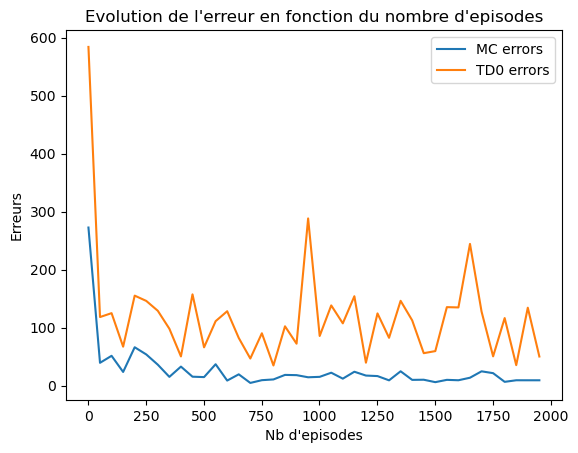

In [11]:
MC_errors = np.array(MC_errors)
TD0_errors = np.array(TD0_errors)

fig, ax = plt.subplots()

ax.plot(range(1,2000,50),MC_errors, label='MC errors')
ax.plot(range(1,2000,50),TD0_errors, label='TD0 errors')

ax.set(xlabel="Nb d'episodes", ylabel='Erreurs', title="Evolution de l'erreur en fonction du nombre d'episodes")
ax.legend()

plt.show()

On constate que l'algorithme MC a convergé rapidement alors que la distance entre l'algorithme TD0 et ipe  osctille entre 50 et 200. Cela s'explique par le fait que MC est efficace avec de petites valeurs et trouve rapidement les bonnes valeurs.

### Execice 2 - Contrôle 

Implémentation de la methode E-greedy

In [12]:
def egreedy(q, s, nb_episode, epsilon, D):
    
    if nb_episode <= D:
        ep = epsilon
    else:
        ep = epsilon / math.sqrt(nb_episode - D)
    
    if np.random.rand()<ep:     
        return np.random.randint(0, q.shape[1])
    else:
        return np.argmax(q[s])

Implémentation de la methode Softmax

In [13]:
def softmax(q, s, nb_episode, T0, D):
    
    if nb_episode <= D:
        T = T0
    else:
        T = T0 / math.sqrt(nb_episode - D)
        
    exp_val = [math.exp(i / T) for i in q[s]]
    softmax_values = [i / np.sum(exp_val) for i in exp_val]
    return random.choices(range(len(q[s])), np.divide(softmax_values, np.sum(softmax_values)), k=1)[0]

Implémentation de la methode Greedy-optimiste

In [ ]:
def greedy(q, s):
    return np.argmax(q[s])

Pour simplifier l'excution des algorithmes avec les différentes méthodes de gestion du dilemme Exploration-Exploitation, nous avons ajouter un argement nomme "methode" pour chaque algorithme, cet argument permet de specifier le methode utilise pour l'Exploration-Exploitation, on lui donne par defaut la methode "egreedy".

Implémentation de l'algorithme de contrôle Monte-Carlo-GLIE (MC)

In [14]:
def monte_carlo_control(env, gamma = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy"):
    
    na = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), na))
    n = np.zeros((env.get_nb_states(), na))
    
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    pi = np.ones((env.get_nb_states(), na)) / na
    print(pi.shape)
    
    for k in range(1, nb_ep_limit+1):
        
        s = env.reset()
        episode = []
        
        while not env.is_final(s):
            a = np.random.choice(na, p = [0.25,0.25,0.25,0.25]) 
            ns, r, _, _ = env.step(a)
            episode.append([s, a, ns, r])
            s = ns
        
        retour = 0
        
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            n[s, a] += 1
            q[s, a] += 1/n[s, a]*(retour - q[s, a])
        
        epsilon = 1 / k
        
        if methode == "egreedy":
            pi = egreedy(q, s, len(episode), epsilon, D)
        
        elif methode == "softmax":
            pi = softmax(q, s, len(episode), T0, D)
        
        else:
            print("Méthode non reconnue")
            sys.exit()
        
        pi = egreedy(q, s, len(episode), epsilon, D) 
        gain[k-1] = retour
        nbs[k-1] = len(episode)
        
    return gain

Implémentation de l'algorithme de contrôle Q-learning (QL)

In [44]:
def Ql(env, gamma = 0.1, alpha = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy", Rmax=1000):
    
    na = env.get_nb_actions()   
    
    if (methode == "greedy optimist"):
        q = np.full((env.get_nb_states(), na), Rmax/(1-gamma))
    else:
        q = np.zeros((env.get_nb_states(), na))
    
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    for k in range(1, nb_ep_limit+1):      
        
        s = env.reset()
        while not env.is_final(s):
            
            if methode == "egreedy":
                a = egreedy(q, s, k, epsilon, D)
            elif methode == "softmax":
                a = softmax(q, s, k, T0, D)
            elif methode == "greedy optimist":
                a = greedy(q,s)
            else:
                print("Méthode non reconnue")
                sys.exit()
            
            ns, r, final, _ = env.step(a)
            
            if final:
            
                target = r
            else:
                target = r + gamma * np.max(q[ns])
            
            gain[k-1] += r
            nbs[k-1] += 1
            q[s, a] += alpha * (target - q[s, a])
            s = ns
    
    return gain

Implémentation de l'algorithme de contrôle Sarsa

In [18]:
def Sarsa(env, gamma = 0.9, alpha = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy",Rmax=1000):
    
    na = env.get_nb_actions()
    
    if (methode == "greedy optimist"):
        q = np.full((env.get_nb_states(), na), Rmax/(1-gamma))
    else:
        q = np.zeros((env.get_nb_states(), na))
        
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    for k in range(1, nb_ep_limit+1):      
        
        s = env.reset()
        
        if methode == "egreedy":
            a = egreedy(q, s, k, epsilon, D)
        elif methode == "softmax":
            a = softmax(q, s, k, T0, D)
        elif methode == "greedy optimist":
            a = greedy(q,s)
        else:
            print("Méthode non reconnue")
            sys.exit()
            
        while not env.is_final(s):
            
            ns, r, final, _ = env.step(a)
            
            if methode == "egreedy":
                na = egreedy(q, ns, k, epsilon, D)
            elif methode == "softmax":
                na = softmax(q, ns, k, T0, D)
            elif methode == "greedy optimist":
                na = greedy(q,ns)
                print(a)
            else:
                print("Méthode non reconnue")
                sys.exit()

            if final:
                
                target = r
            else:
                target = r + gamma * q[ns,na]
                
            gain[k-1] += r
            nbs[k-1] += 1
            q[s, a] += alpha * (target - q[s, a])
            s = ns
            a=na
    
    return gain

<AxesSubplot: >

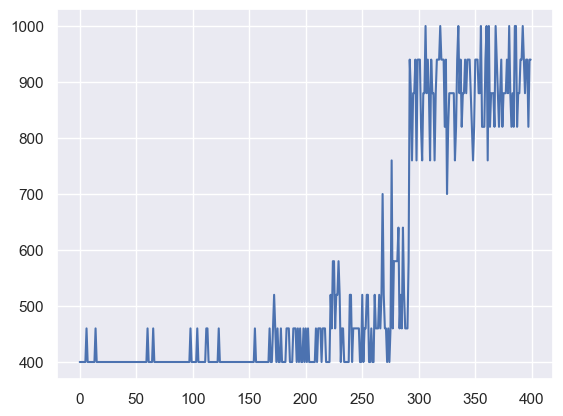

In [25]:
def generate(algo, env, gamma = 0.9, alpha = 0.1, epsilon=0.5, nb_ep_limit = 5000, D=4000):
    liste=algo(env, gamma, alpha, epsilon, nb_ep_limit, D)
    liste = liste.reshape(-1,10).mean(axis=1)
    sns.set_theme(style="darkgrid")
    return sns.lineplot(liste)

generate(sarsa, env)   

In [42]:
def generate(algo, env, gamma, alpha, epsilon, nb_ep_limit = 5000, D=4000 , methode = "egreedy"):
    result = np.empty((len(gamma), len(alpha), len(epsilon),200))
    for i,gam in enumerate(gamma):
        for j,alp in enumerate(alpha):
            for k,ep in enumerate(epsilon):
                result[i][j][k]=algo(env,gam,alp,ep, nb_ep_limit, D, methode = "egreedy").reshape(-1,20).mean(axis=1)
                sns.set_theme(style="darkgrid")
                sns.lineplot(result[i][j][k],label=f"gamma={gam}, alpha={alp}, epsilon={ep}", linewidth=2)

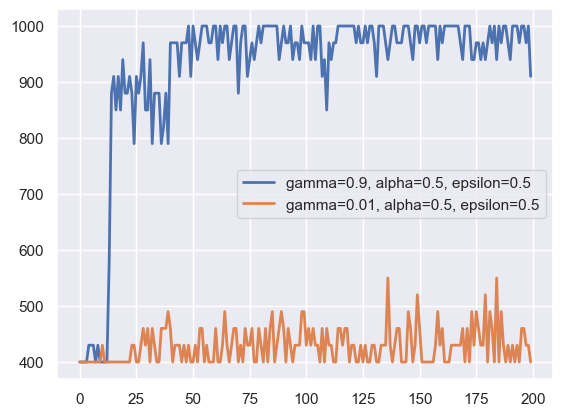

In [43]:
generate(qlearning, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=4000 , methode = "egreedy")